# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [188]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [189]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [190]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1},
                       seed=-1, cache_theta=True)
# число после названия модальностей - это их веса

In [191]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary1'), overwrite=True)
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"), overwrite=True)
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"), overwrite=True)

Создаем словарь и инициализируем модель с его помощью

In [192]:
dictionary1 = artm.Dictionary()
dictionary1.gather(data_path="school_batches")

In [193]:
model_artm.initialize(dictionary=dictionary1)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [194]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

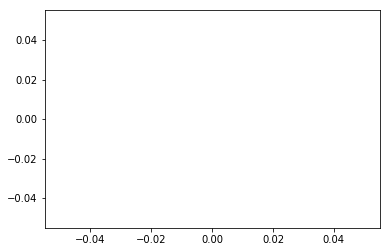

In [195]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [197]:
tokens_for_topics = model_artm.score_tracker['top_words'].last_tokens
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    for word in tokens_for_topics[topic_name]:
        print(word, end=' ')
    print('')

sbj0: 
быть право который ребенок человек язык они семья это русский время для также свой что 
sbj1: 
что свой который быть это человек этот его герой она они жизнь ребенок как такой 
sbj2: 
предложение слово который что например это как быть или речь такой они если мочь этот 
sbj3: 
который что ядро это этот энергия вода земля быть масса атом как температура такой океан 
sbj4: 
поэт пушкин что стихотворение который свой это быть звук этот весь лирика год его произведение 
sbj5: 
x быть a b число этот при функция уравнение что это для если сила ток 
sbj6: 
который человек свой что жизнь его быть герой это как произведение литература этот для русский 
sbj7: 
который человек общество развитие социальный государство как политический быть это себя культура жизнь такой отношение 
sbj8: 
страна государство население который быть территория этот год являться город африка время что также хозяйство 
sbj9: 
быть который год государство война становиться свой что весь первый военный как время пер

Давайте посмотрим также на разреженность матриц:

In [198]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7677122950553894
0.0018907563062384725


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [199]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary1), overwrite=True)
#model_artm.regularizers['SparsePhi'].tau = -100
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [200]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [201]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [202]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [203]:
tokens_for_topics = model_artm.score_tracker['top_words'].last_tokens
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    for word in tokens_for_topics[topic_name]:
        print(word, end=' ')
    print('')

sbj0: 
право ребенок язык свобода семья английский религиозный гражданский быт суд воспитание честь орган the закреплять 
sbj1: 
жить повесть женщина нет лермонтов поэма написать школа молодой сказка отец хороший любить гоголь умирать 
sbj2: 
слово например предложение простой какой речь предмет глагол скорость физика имя выступать свет кто угол 
sbj3: 
земля энергия вода ядро масса движение природный состоять океан частица атом заряд температура располагать южный 
sbj4: 
пушкин поэт стихотворение звук писать лирика стих поэзия сравнение почти русь ночь былина красота любовный 
sbj5: 
при x a сила если два число можно b функция пример получать тело равный случай 
sbj6: 
человек его жизнь герой русский главный произведение мир литература сам история автор литературный личность всегда 
sbj7: 
общество представлять развитие отношение социальный политический процесс форма система экономический производство культура характер понятие роль 
sbj8: 
страна территория население город древний сев

In [204]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9007267355918884
0.09810924530029297


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [205]:
model_artm.save("my_model")

In [206]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [207]:
phi = model_artm.get_phi()

In [208]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, домохозяйка)",0.000000,0.000000,0.000128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(text, институт)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002400,0.000000,0.000000
"(text, машинка)",0.000000,0.000000,0.000000,0.000000,0.000243,0.000000,0.000000,0.000000,0.000000,0.000000
"(text, прочий)",0.000000,0.001107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(text, навязнуть)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000000,0.000000,0.000000
"(text, физиология)",0.000000,0.000415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(text, истязать)",0.000223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(text, выборы)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000984
"(text, кндр)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000283,0.000000
"(text, федерализм)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000


Матрица вероятностей тем в документах.

In [209]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,90,91,92,93,94,95,96,97,98,99
sbj0,0.007968,3.690034e-03,0.047431,0.000000e+00,0.384185,0.008230,6.343284e-02,0.012605,0.000000,0.000000,...,0.010050,0.011719,0.005376,8.130087e-03,0.039683,0.000000,0.008734,0.000000,0.016707,0.055336
sbj1,0.011952,3.690034e-03,0.079051,2.702704e-02,0.120516,0.404832,2.238806e-02,0.474183,0.007905,0.010417,...,0.010622,0.003906,0.005376,1.219513e-02,0.281369,0.000000,0.343784,0.316326,0.117647,0.494071
sbj2,0.000000,3.713151e-03,0.375263,4.504507e-03,0.012764,0.012400,2.611940e-02,0.024567,0.047431,0.026042,...,0.688420,0.011755,0.306452,2.135411e-10,0.007937,0.140541,0.017467,0.051020,0.297018,0.039526
sbj3,0.023904,6.752538e-01,0.031621,6.171169e-01,0.067687,0.012346,8.955225e-02,0.013524,0.541380,0.052083,...,0.005025,0.125000,0.005376,1.219513e-02,0.019841,0.567567,0.004367,0.163265,0.015217,0.000000
sbj4,0.007968,1.212870e-09,0.000000,7.820002e-08,0.008368,0.152257,2.781986e-15,0.029412,0.000000,0.005208,...,0.005025,0.003906,0.021505,4.156237e-03,0.008089,0.000000,0.021834,0.183520,0.034314,0.007905
sbj5,0.015936,4.059038e-02,0.043478,2.702704e-02,0.054562,0.057771,7.089552e-02,0.021086,0.276680,0.046875,...,0.130081,0.031250,0.591398,5.284556e-02,0.039683,0.270270,0.021834,0.153061,0.077920,0.051383
sbj6,0.346613,1.476014e-02,0.291878,1.801803e-02,0.104602,0.164609,3.171640e-01,0.302521,0.027789,0.088542,...,0.080402,0.007812,0.032258,1.016261e-01,0.484127,0.016216,0.301310,0.045918,0.298699,0.158103
sbj7,0.282869,4.797044e-02,0.083004,4.054057e-02,0.063026,0.035111,7.089552e-02,0.025210,0.019763,0.718750,...,0.005025,0.066406,0.016129,5.771442e-01,0.051697,0.000000,0.061135,0.056122,0.034314,0.075099
sbj8,0.075697,1.660516e-01,0.020089,2.297298e-01,0.125713,0.012396,2.723882e-01,0.033613,0.039526,0.005208,...,0.005048,0.558558,0.010753,1.626017e-02,0.012020,0.000000,0.039301,0.005102,0.009804,0.019763
sbj9,0.227092,4.428041e-02,0.028185,3.603606e-02,0.058577,0.140048,6.716416e-02,0.063278,0.039526,0.046875,...,0.060301,0.179687,0.005376,2.154474e-01,0.055556,0.005405,0.180234,0.025664,0.098360,0.098814


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [211]:
theta_test = model_artm.transform(batch_vectorizer)